In [1]:
from tensorflow.keras.utils    import to_categorical
from tensorflow.keras.datasets import mnist

from sklearn.datasets        import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder, StandardScaler


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
os.environ['PATH'] = '/tools/Xilinx/Vivado/2020.1/bin:' + os.environ['PATH']

import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 420

tf.random.set_seed(seed)
np.random.seed    (seed)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-nyv7hple because the default path (/home/gabri-bot/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
USER_PATH    = os.getcwd()
DATA_PATH    = USER_PATH + "/Data/"
MODEL_PATH   = USER_PATH + "/Models/"
PROJECT_PATH = USER_PATH + "/HLS_projects/"
PLOTS_PATH   = USER_PATH + "/Plots/"

In [3]:
from tensorflow.keras.models       import Sequential
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers       import Activation, BatchNormalization, Flatten, MaxPool2D, Reshape
from tensorflow.keras.layers       import Dense, Conv2D

from utils.callbacks import all_callbacks

from qkeras.qlayers    import QDense, QActivation
from qkeras            import QConv2D, QConv1D
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_tanh

In [4]:
from tensorflow.keras.datasets import mnist
from qkeras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical

In [5]:
from tensorflow.keras.models import model_from_json
from qkeras.utils import _add_supported_quantized_objects; co = {}; _add_supported_quantized_objects(co)

def get_example_cnn_qmodel():
    jsons = open('Models/hls4_example/qkeras_mnist_cnn.json','r').read()
    model = model_from_json(jsons, custom_objects=co)
    model.load_weights('Models/hls4_example/qkeras_mnist_cnn_weights.h5')

    print_qstats(model)

    return model

def get_example_dense_qmodel():
    jsons = open('Models/hls4_example/qkeras_mnist_dense.json','r').read()
    model = model_from_json(jsons, custom_objects=co)
    model.load_weights('Models/hls4_example/qkeras_mnist_dense_weights.h5')

    print_qstats(model)

    return model

def get_cnn_qmodel():
    x = x_in = Input((28,28,1), name="layer0")
    x = QConv2D(
        16, (3, 3),
        kernel_quantizer=quantized_bits(4,1,0,alpha=1),
        bias_quantizer=quantized_bits(7,0,0,alpha=1),
        name="q_conv2d")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu")(x)
    x = MaxPooling2D((2,2), name='maxp')(x)
    x = QConv2D(
        16, (3, 3),
        kernel_quantizer=quantized_bits(5,0,0,alpha=1),
        bias_quantizer=quantized_bits(6,0,0,alpha=1),
        name="q_conv2d_1")(x)
    x = QActivation("quantized_relu(3,1)", name="1_relu_1")(x)
    x = MaxPooling2D((2,2), name='maxp_1')(x)
    #x = Conv2D(36, (3,3),
    #          name='Conv2')(x)
    #x = MaxPool2D((2,2), name='Max2')(x)
    x = Flatten()(x)
    x = QDense(10, name='q_dense',
              kernel_quantizer=quantized_bits(5,0,0,alpha=1),
              #kernel_quantizer="stochastic_ternary()",
              bias_quantizer=quantized_bits(6,0,0,alpha=1))(x)
    x = Activation("softmax", name='softmax')(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    print_qstats(model)
    
    return model

def get_dense_qmodel():
    x = x_in = Input((784,), name="layer0")
    x = QActivation("quantized_relu(2)", name="q_relu")(x)
    x = QDense(
        20,
        kernel_quantizer = quantized_bits(4,0, alpha=1),
        bias_quantizer   = quantized_bits(5,0, alpha=1),
        name="q_dense")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_1")(x)
    x = QDense(
        10,
        kernel_quantizer = quantized_bits(4,1, alpha=1),
        bias_quantizer   = quantized_bits(4,1, alpha=1),
        name='q_dense_1')(x)
    x = Activation("softmax", name='softmax')(x)
    
    model = Model(inputs=x_in, outputs=x)
    
    print_qstats(model)
    
    return model

In [6]:
def get_train_test_set(nn_type='Dense'):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x_train = x_train / 256.0
    x_test = x_test / 256.0
    
    if (nn_type=='Dense'):
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)
        
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return (x_train, y_train), (x_test, y_test)

# Convolutional neural network

### Get the dataset

In [7]:
(x_train, y_train), (x_test, y_test) = get_train_test_set(nn_type='Conv2d')

### Get the model

In [8]:
model = get_cnn_qmodel()

model.summary()

2021-10-20 23:17:43.364347: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 23:17:43.364480: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libamdhip64.so
2021-10-20 23:17:43.398650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1738] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: Ellesmere [Radeon RX 470/480/570/570X/580/580X]     ROCm AMD GPU ISA: gfx803
coreClock: 1.411GHz coreCount: 36 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 119.21GiB/s
2021-10-20 23:17:43.400632: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library librocblas.so
2021-10-20 23:17:43.402001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libMIOpen.so
2021-10-20 23:17:43.414528: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_conv2d_1                    : 278784 (smult_5_3)
    q_dense                       : 4000  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 282784

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_conv2d_1_weights             : 2304  (5-bit unit)
    q_conv2d_1_bias                : 16    (6-bit unit)
    q_dense_weights                : 4000  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.3125
    q_conv2d_1                     : 0.2065
    q_dense                        : 0.3304
    ----------------------------------------
    Total Sparsity                 : 0.2857
Model: "model"
_____________________________________________________

### Set the pruning parameters

In [9]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras             import strip_pruning

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=360, frequency=180)}
model = prune.prune_low_magnitude(model, **pruning_params)

/home/gabri-bot/TFenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Train the model

In [10]:
train = False
if train:
    
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor     = 0.5,
                              lr_patience   = 20,
                              lr_epsilon    = 0.000001,
                              lr_cooldown   = 5,
                              lr_minimum    = 0.000001,
                              verbose       = False,
                              outputDir = MODEL_PATH + 'Qkeras_pruned_CNN')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    with tf.device('/gpu:0'):
        model.fit(x_train, y_train, batch_size=5000,
                  epochs=200, validation_split=0.25, shuffle=True,
                  verbose = 1,
                  callbacks = callbacks.callbacks)
    with tf.device('/cpu:0'):
    # Save the model again but with the pruning 'stripped' to use the regular layer types
        model = strip_pruning(model)
        model.save( MODEL_PATH + 'Qkeras_pruned_CNN/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model( MODEL_PATH + 'Qkeras_pruned_CNN/KERAS_check_best_model.h5', custom_objects=co)
    model.compile()
    model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
q_conv2d (QConv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
q_relu (QActivation)         (None, 26, 26, 16)        0         
_________________________________________________________________
maxp (MaxPooling2D)          (None, 13, 13, 16)        0         
_________________________________________________________________
q_conv2d_1 (QConv2D)         (None, 11, 11, 16)        2320      
_________________________________________________________________
1_relu_1 (QActivation)       (None, 11, 11, 16)        0         
_________________________________________________________________
maxp_1 (MaxPooling2D)        (None, 5, 5, 16)          0   

% of zeros = 0.75

Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_conv2d_1                    : 278784 (smult_5_3)
    q_dense                       : 4000  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 282784

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_conv2d_1_weights             : 2304  (5-bit unit)
    q_conv2d_1_bias                : 16    (6-bit unit)
    q_dense_weights                : 4000  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.8438
    q_conv2d_1                     : 0.7466
    q_dense                        : 0.7489
    ----------------------------------------
    Total Sparsity                 : 0.7504


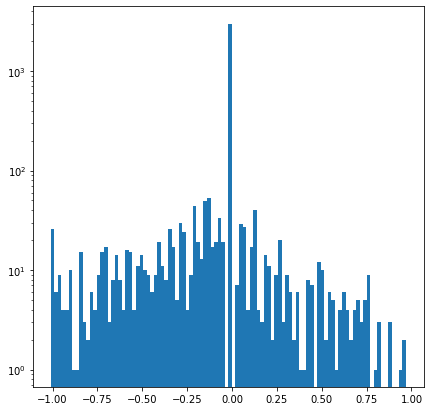

In [11]:
w = model.layers[8].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))




print_qstats(model)

### hls4ml configuration file

In [13]:
import hls4ml
from utils import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

#config['Backend'] = 'vivado_accelerator' 

config['Model'] = {}
config['Model']['ReuseFactor'] = 36
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<16,6>'


config['LayerName']['layer0']['Precision'] = 'ap_fixed<8,3>'

config['LayerName']['q_conv2d']['ReuseFactor'] = 72
config['LayerName']['q_conv2d_1']['ReuseFactor'] = 144
config['LayerName']['q_dense']['ReuseFactor'] = 40

config['SkipOptimizers'] = ['reshape_stream']

#config['LayerName']['bn1']['scale'] = 'ap_fixed<3,1>'
#config['LayerName']['bn1']['bias']  = 'ap_fixed<3,1>'
#config['LayerName']['bn1']['Precision']  = 'ap_fixed<12,4>'


config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<12,4>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<12,2>'
config['LayerName']['softmax']['Precision'] = 'ap_fixed<16,6>'
config['LayerName']['softmax']['Strategy'] = 'Stable'

cfg = hls4ml.converters.create_backend_config(fpga_part='xc7z020clg400-1')
cfg['HLSConfig'] = config
cfg['IOType']= 'io_stream'
cfg['Backend'] = 'Pynq'
cfg['Interface'] = 's_axilite'
#cfg['Interface'] = 'm_axi'
cfg['KerasModel'] = model
cfg['OutputDir'] = PROJECT_PATH + 'Qkeras_pruned_CNN/hls4ml_PYNQ_prj'

print("-----------------------------------")
plotting.print_dict(cfg)
print("-----------------------------------")
hls_model = hls4ml.converters.keras_to_hls(cfg)
#hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)


#print("-----------------------------------")
#plotting.print_dict(config)
#print("-----------------------------------")
#hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                       hls_config=config,
#                                                       output_dir='model_3/hls4ml_prj',
#           

Interpreting Model
Topology:
Layer name: layer0, layer type: Input
Layer name: q_conv2d, layer type: QConv2D
Layer name: q_relu, layer type: QActivation
Layer name: maxp, layer type: MaxPooling2D
Layer name: q_conv2d_1, layer type: QConv2D
Layer name: 1_relu_1, layer type: QActivation
Layer name: maxp_1, layer type: MaxPooling2D
Layer name: q_dense, layer type: QDense
Layer name: softmax, layer type: Activation
-----------------------------------
OutputDir:           /home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_CNN/hls4ml_PYNQ_prj
ProjectName:         myproject
XilinxPart:          xc7z020clg400-1
ClockPeriod:         5
Backend:             Pynq
IOType:              io_stream
HLSConfig
  Model
    ReuseFactor:     36
    Strategy:        Resource
    Precision:       ap_fixed<16,6>
  LayerName
    layer0
      Precision:     ap_fixed<8,3>
    q_conv2d
      Precision
        weight:      ap_fixed<4,2>
        bias:        ap_fixed<7,1>
     

### Check accuracy and expected AUC

In [30]:
hls_model.compile()

Writing HLS project
Done


In [31]:
with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
y_hls = hls_model.predict(np.ascontiguousarray(x_test))

In [32]:
np.save(MODEL_PATH + 'Qkeras_pruned_CNN/HLS_data/y_hls.npy', y_hls)
np.save(DATA_PATH + 'y_hls_CNN.npy', y_hls)

Accuracy pruned, quantized: 0.9788
Accuracy hls4ml: 0.9734


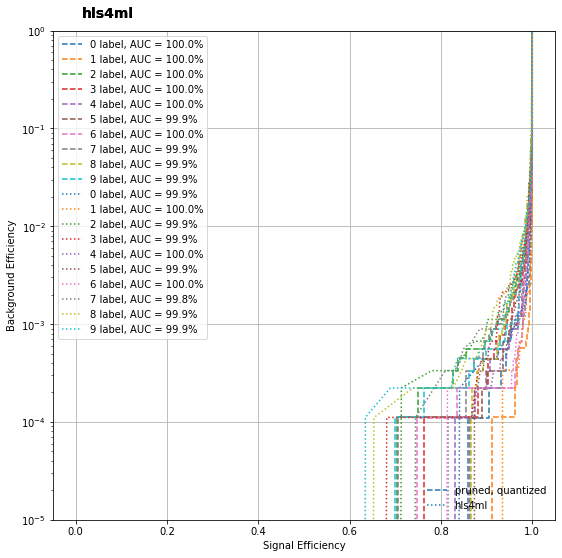

In [33]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':')

from matplotlib.lines import Line2D
lines = [#Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

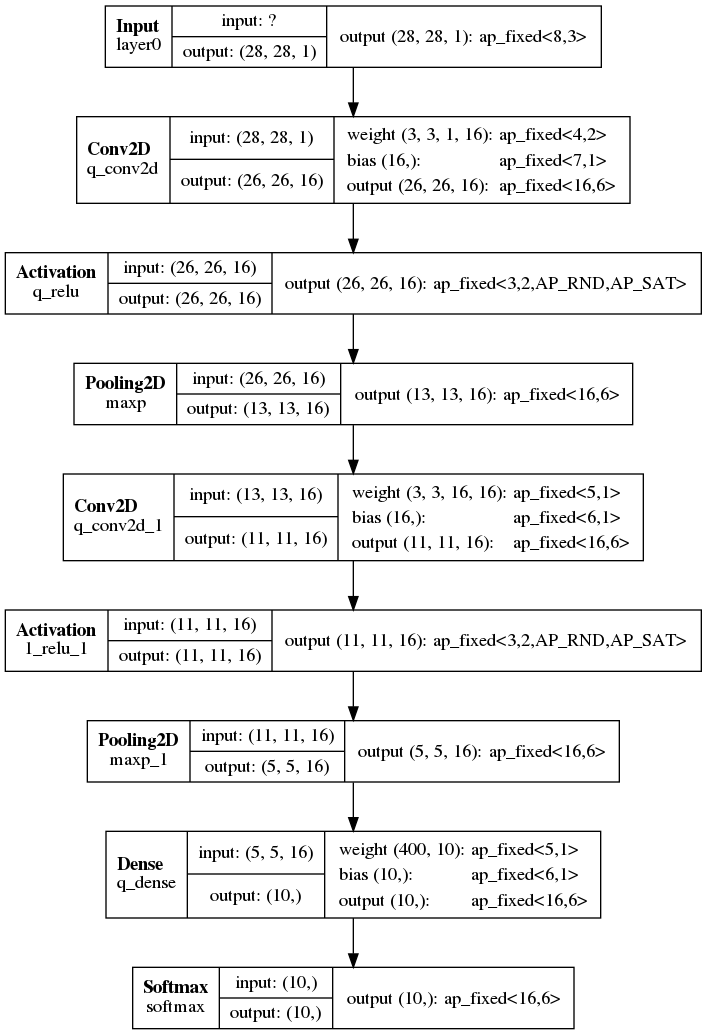

In [34]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

### Build the ip

In [ ]:
hls_model.build(csim=False,synth=True,export=True)

In [36]:
hls4ml.report.read_vivado_report(PROJECT_PATH + 'Qkeras_pruned_CNN/hls4ml_PYNQ_prj')

Found 1 solution(s) in /home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_CNN/hls4ml_PYNQ_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Wed Oct 20 11:53:55 2021

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 6.325 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-------+-------+---------+
    |  Latency (cycles) |  Latency (absolute) |    Interval   | Pipeline|
    |   min   | 

### FPGA Comparison

Compute the output array in the fpga and save it as y_pynq

Accuracy pruned, quantized: 0.9788
Accuracy hls4ml: 0.9734
Accuracy FPGA: 0.9725


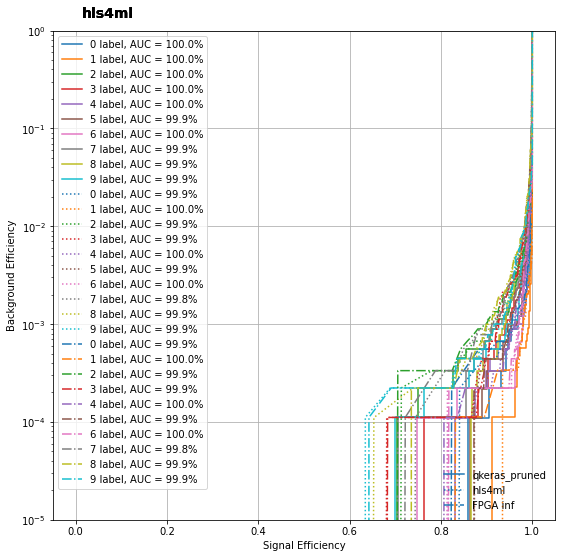

In [14]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
    
y_hls = np.load(DATA_PATH + 'y_hls_CNN.npy')

y_FPGA = np.load(DATA_PATH + 'y_pynq_CNN.npy') 

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print("Accuracy FPGA: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_FPGA, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]                )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':' )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_FPGA  , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='-.')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls=':'),
         Line2D([0], [0], ls='-.')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['qkeras_pruned', 'hls4ml', 'FPGA inf'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

fig.facecolor='yellow'

fig.savefig(PLOTS_PATH + '/Final_AUC_plot', bbox_inches='tight')

# Dense model

### Get the dataset

In [7]:
(x_train, y_train), (x_test, y_test) = get_train_test_set(nn_type='Dense')

### Get the model

In [8]:
model = get_dense_qmodel()

model.summary()

2021-10-20 21:01:00.468938: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 21:01:00.469379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libamdhip64.so
2021-10-20 21:01:00.596253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1738] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: Ellesmere [Radeon RX 470/480/570/570X/580/580X]     ROCm AMD GPU ISA: gfx803
coreClock: 1.411GHz coreCount: 36 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 119.21GiB/s
2021-10-20 21:01:00.674275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library librocblas.so
2021-10-20 21:01:00.681085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libMIOpen.so
2021-10-20 21:01:00.739880: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_dense                       : 15680 (smult_4_2)
    q_dense_1                     : 200   (smult_4_3)

Number of operation types in model:
    smult_4_2                     : 15680
    smult_4_3                     : 200

Weight profiling:
    q_dense_weights                : 15680 (4-bit unit)
    q_dense_bias                   : 20    (5-bit unit)
    q_dense_1_weights              : 200   (4-bit unit)
    q_dense_1_bias                 : 10    (4-bit unit)

Weight sparsity:
... quantizing model
    q_dense                        : 0.6600
    q_dense_1                      : 0.2905
    ----------------------------------------
    Total Sparsity                 : 0.6551
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
q_r

In [9]:
pruning  = True

In [14]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras             import strip_pruning

if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.80, begin_step=2000, frequency=400)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [ ]:
train = True
if train:
    
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor     = 0.5,
                              lr_patience   = 20,
                              lr_epsilon    = 0.000001,
                              lr_cooldown   = 5,
                              lr_minimum    = 0.000001,
                              verbose       = False,
                              outputDir = MODEL_PATH + 'Qkeras_pruned_Dense')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    with tf.device('/cpu:0'):
        model.fit(x_train, y_train, batch_size=256,
                  epochs=100, validation_split=0.25, shuffle=True,
                  verbose = 1,
                  callbacks = callbacks.callbacks)
    with tf.device('/cpu:0'):
    # Save the model again but with the pruning 'stripped' to use the regular layer types
        if pruning:
            model = strip_pruning(model)
        model.save( MODEL_PATH + 'Qkeras_pruned_Dense/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model( MODEL_PATH + 'Qkeras_pruned_Dense/KERAS_check_best_model.h5', custom_objects=co)
    model.compile()
    model.summary()

% of zeros = 0.8

Number of operations in model:
    q_dense                       : 15680 (smult_4_2)
    q_dense_1                     : 200   (smult_4_3)

Number of operation types in model:
    smult_4_2                     : 15680
    smult_4_3                     : 200

Weight profiling:
    q_dense_weights                : 15680 (4-bit unit)
    q_dense_bias                   : 20    (5-bit unit)
    q_dense_1_weights              : 200   (4-bit unit)
    q_dense_1_bias                 : 10    (4-bit unit)

Weight sparsity:
... quantizing model
    q_dense                        : 0.8063
    q_dense_1                      : 0.7667
    ----------------------------------------
    Total Sparsity                 : 0.8058


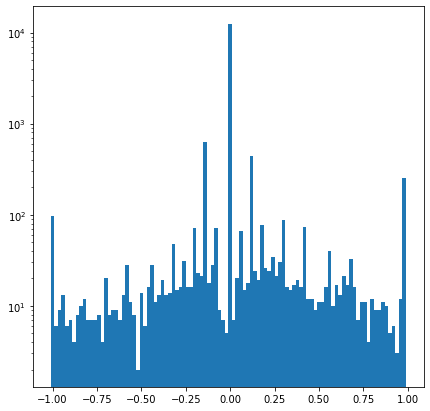

In [16]:
w = model.layers[2].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))



print_qstats(model)

Interpreting Model
Topology:
Layer name: layer0, layer type: Input
Layer name: q_relu, layer type: QActivation
Layer name: q_dense, layer type: QDense
Layer name: q_relu_1, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: softmax, layer type: Activation
-----------------------------------
OutputDir:           /home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj
ProjectName:         myproject
XilinxPart:          xc7z020clg400-1
ClockPeriod:         5
Backend:             Pynq
IOType:              io_parallel
HLSConfig
  Model
    ReuseFactor:     20
    Strategy:        Resource
    Precision:       ap_fixed<16,6>
  LayerName
    layer0
      Precision:     ap_fixed<8,3>
    q_relu
      Precision
        result:      ap_fixed<2,1>
      ReuseFactor:   1
    q_dense
      Precision
        weight:      ap_fixed<4,1>
        bias:        ap_fixed<5,1>
      ReuseFactor:   56
    q_relu_1
      Precis

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 None,
 None)

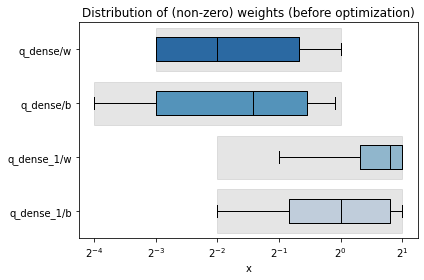

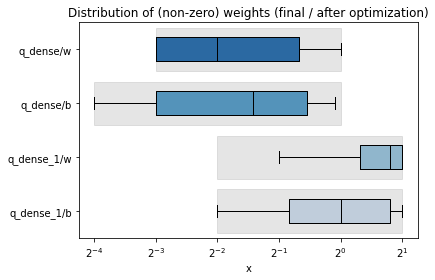

In [17]:
import hls4ml
from utils import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

#config['Backend'] = 'vivado_accelerator' 

config['Model'] = {}
config['Model']['ReuseFactor'] = 20
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<16,6>'


config['LayerName']['layer0']['Precision'] = 'ap_fixed<8,3>'

config['LayerName']['q_dense']['ReuseFactor'] = 56
config['LayerName']['q_dense_1']['ReuseFactor'] = 20

#config['SkipOptimizers'] = ['reshape_stream']

#config['LayerName']['bn1']['scale'] = 'ap_fixed<3,1>'
#config['LayerName']['bn1']['bias']  = 'ap_fixed<3,1>'
#config['LayerName']['bn1']['Precision']  = 'ap_fixed<12,4>'


config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<12,4>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<12,2>'
config['LayerName']['softmax']['Precision'] = 'ap_fixed<16,6>'
config['LayerName']['softmax']['Strategy'] = 'Stable'

cfg = hls4ml.converters.create_backend_config(fpga_part='xc7z020clg400-1')
cfg['HLSConfig'] = config
cfg['IOType']= 'io_parallel'
cfg['Backend'] = 'Pynq'
cfg['Interface'] = 's_axilite'
#cfg['Interface'] = 'm_axi'
cfg['KerasModel'] = model
cfg['OutputDir'] = PROJECT_PATH + 'Qkeras_pruned_Dense/hls4ml_PYNQ_prj'

print("-----------------------------------")
plotting.print_dict(cfg)
print("-----------------------------------")
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)


#print("-----------------------------------")
#plotting.print_dict(config)
#print("-----------------------------------")
#hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                       hls_config=config,
#                                                       output_dir='model_3/hls4ml_prj',
#        

In [18]:
hls_model.compile()

with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))

y_hls = hls_model.predict(np.ascontiguousarray(x_test))

Writing HLS project
Done


In [19]:
np.save(MODEL_PATH + 'Qkeras_pruned_Dense/HLS_data/y_hls.npy', y_hls)
np.save(DATA_PATH + 'y_hls_Dense.npy', y_hls)

Accuracy pruned, quantized: 0.9209
Accuracy hls4ml: 0.9062


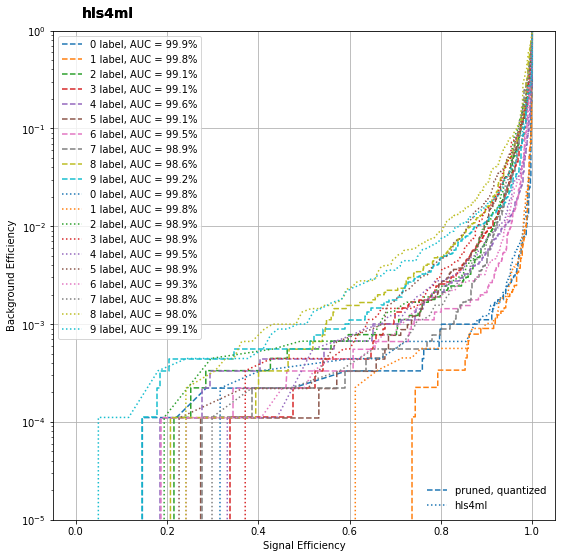

In [20]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':')

from matplotlib.lines import Line2D
lines = [#Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

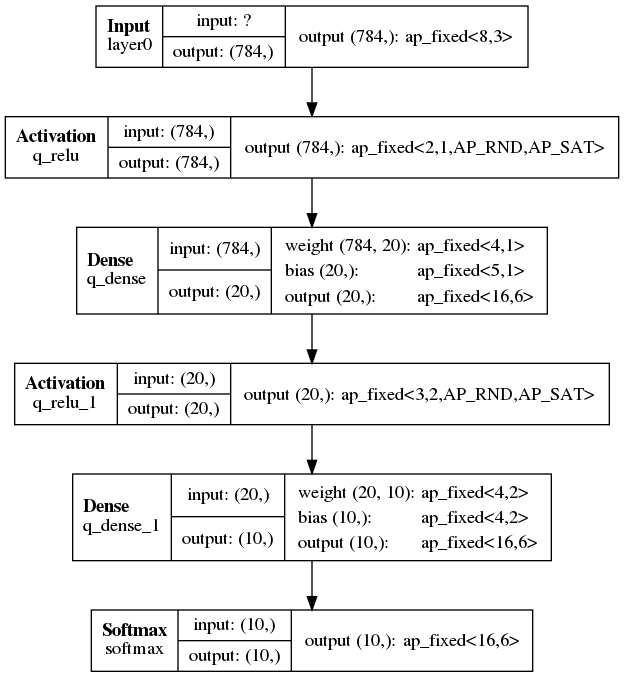

In [21]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
hls_model.build(csim=False,synth=True,export=True)

In [23]:
hls4ml.report.read_vivado_report(PROJECT_PATH + 'Qkeras_pruned_Dense/hls4ml_PYNQ_prj')

Found 1 solution(s) in /home/gabri-bot/University/Git_hub/PYNQ_IA/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_Dense/hls4ml_PYNQ_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject_axi'
* Date:           Wed Oct 20 21:32:40 2021

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.039 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+---------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline|
    |   min   |   max 

Accuracy pruned, quantized: 0.9209
Accuracy hls4ml: 0.9062
Accuracy FPGA: 0.9062


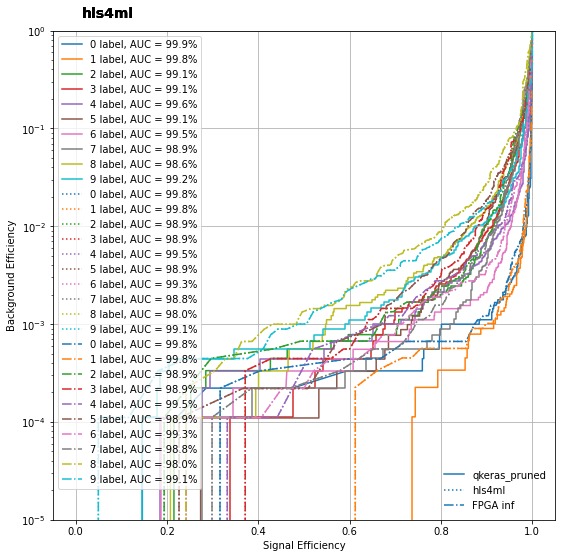

In [24]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
    
y_hls = np.load(DATA_PATH + 'y_hls_Dense.npy')

y_FPGA = np.load(DATA_PATH + 'y_pynq_DNN.npy') 

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print("Accuracy FPGA: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_FPGA, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]                )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':' )
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_FPGA  , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='-.')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls=':'),
         Line2D([0], [0], ls='-.')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['qkeras_pruned', 'hls4ml', 'FPGA inf'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

fig.facecolor='yellow'

fig.savefig(PLOTS_PATH + '/Final_AUC_plot', bbox_inches='tight')